In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.profiler import profile, record_function, ProfilerActivity

from os import listdir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(20020109)

text_data_dir = "./text_data/"
num_train_dir =  "./num_aggregated_data/"


cuda


In [2]:

class TrainDataset(Dataset):
    def __init__ (self, shortterm_input_seq_len, longterm_input_seq_len, output_seq_len, noise_factor, ):
        self.traindf = pd.concat([pd.read_pickle(num_train_dir + "train2"),pd.read_pickle(num_train_dir + "test2")], axis=0)
        print("loaded train df: ", self.traindf.shape)

        self.shortterm_input_seq_len = shortterm_input_seq_len
        self.longterm_input_seq_len = longterm_input_seq_len
        self.output_seq_len = output_seq_len
        self.noise_factor = noise_factor
        
        self.min_idx = longterm_input_seq_len
        self.max_idx = 7200 - self.output_seq_len # just value for train test split
           
    def __len__(self):
        return self.max_idx - self.min_idx
    def __getitem__(self, index):
        index = self.min_idx + index
        # print(index)
        # gather all previous days of numerical data
        segment = self.traindf.iloc[index-self.longterm_input_seq_len: index+self.output_seq_len]
        # get "today"
        index_day = segment.iloc[self.longterm_input_seq_len]["Date"]
        # remove dates column because it cant be a tensor
        segment = segment.drop(columns=['Date'])
        colnames = segment.columns # save the column names for inference use
        # fit scaler using just the input portion, but scale everything including the target
        input_portion = segment.iloc[1:self.longterm_input_seq_len+1,:]
        scaler = StandardScaler()
        scaler.fit(input_portion)
        segment = scaler.transform(segment)
        # longterm numeric input, apply differencing to detrend, add noise, conver to tensor 
        lnumin = segment[1:self.longterm_input_seq_len+1,:]
        lnumin = self.difference(lnumin)
        longterm_var = np.var(lnumin, axis=0)
        noise_scaled_by_variance = np.random.normal(loc=0, scale=self.noise_factor*np.sqrt(longterm_var), size=lnumin.shape)
        lnumin = lnumin + noise_scaled_by_variance
        lnumin = torch.tensor(lnumin).float()
        # shortterm numeric input, apply differencing to detrend, add noise, conver to tensor
        snumin = segment[self.longterm_input_seq_len - self.shortterm_input_seq_len + 1: self.longterm_input_seq_len+1, :]
        snumin = self.difference(snumin)
        shortterm_var = np.var(snumin, axis=0)
        noise_scaled_by_variance = np.random.normal(loc=0, scale=self.noise_factor*np.sqrt(shortterm_var), size=snumin.shape)
        snumin = snumin + noise_scaled_by_variance
        snumin = torch.tensor(snumin).float()
        # target, apply differencing, convert to tensor
        numout = segment[self.longterm_input_seq_len:,:]
        initial_value = numout[0,:]
        numout = self.difference(numout)
        numout = torch.tensor(numout).float()
        # the sample with extra data is for inferencing
        # sample = {"lnumin":lnumin, "snumin":snumin, "numout": numout,"colnames": colnames,"scale": scaler, "startday": index_day, "initial_value":initial_value}
        sample = {"lnumin":lnumin, "snumin":snumin, "numout": numout}
        return sample
    
    def difference(self, x):
        differences = np.diff(x, axis=0)
        differences = np.vstack((np.zeros((1, differences.shape[1])), differences))  # Fill the first row with zeros
        return differences

In [3]:
class LFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # since numeric data has patterns and cycles, use convolution and pooling to capture those patterns, and generate embeddings for later use
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=4, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, stride=2)
        self.relu2 = nn.ReLU()
        self.conv4 = nn.Conv1d(64, out_channels, kernel_size=8,stride=4)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(4,2,padding=2)
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = torch.permute(x, [0,2,1]).contiguous() # conv operations need a different shape than linear, this will be undoed later
        a = self.conv1(x)
        a = self.relu1(a)
        a = self.conv2(a)
        a = self.relu2(a)
        a = self.conv4(a)
        a = self.relu4(a)
        a = self.maxpool(a)
        a = self.bn(a)
        # print(a.shape)
        return a

class SFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        # print(output.shape)
        return output
    
# class Upsampler(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.linear1 = nn.Linear(in_channels, 64)
#         self.relu1 = nn.ReLU()
#         self.linear2 = nn.Linear(64, 256)
#         self.relu2 = nn.ReLU()
#         self.linear3 = nn.Linear(256, out_channels)
#         self.norm = nn.LayerNorm(out_channels)
#     def forward(self, x):
#         a = self.linear1(x)
#         a = self.relu1(a)
#         a = self.linear2(a)
#         a = self.relu2(a)
#         a = self.linear3(a)
#         a = self.norm(a)
#         return a

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # plt.figure(figsize=(10, 8))
        # attention = attn_probs[4, 1, :, :].cpu().detach().numpy() 
        # sns.heatmap(attention, annot=False, square=True)
        # plt.title('Attention Scores Heatmap')
        # plt.ylabel('Query Positions')
        # plt.xlabel('Key Positions')
        # plt.show()
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [6]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, snumin, lnumin):
        attn_output = self.self_attn(snumin, snumin, snumin, None)
        snumin = self.norm1(snumin + self.dropout(attn_output))
        attn_output = self.cross_attn(snumin, lnumin, lnumin, None)
        snumin = self.norm2(snumin + self.dropout(attn_output))
        ff_output = self.feed_forward(snumin)
        snumin = self.norm3(snumin + self.dropout(ff_output))
        return snumin
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output):
        attn_output = self.self_attn(x, x, x, None)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, None)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class PredictBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.linear1 = nn.Linear(in_channels, 256)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Initialize dropout with the passed rate
        self.linear4 = nn.Linear(64, out_channels)
        
    def forward(self, x):
        a = self.linear1(x)
        a = self.relu1(a)
        a = self.linear2(a)
        a = self.relu2(a)
        a = self.linear3(a)
        a = self.relu3(a)
        a = self.dropout(a)  # Apply dropout after activation
        a = self.linear4(a)
        return a

In [7]:
class Transformer(nn.Module):
    def __init__(self, input_size, input_max_len, d_model, num_heads, num_layers, d_ff, dropout):
        super(Transformer, self).__init__()

        self.longfeat = LFeatureExtractor(input_size, d_model)
        self.shortfeat = SFeatureExtractor(input_size, d_model // 2, num_layers)
        self.outfeat = SFeatureExtractor(input_size, d_model // 2, num_layers)
        # self.outfeat = Upsampler(input_size, d_model)
        self.posen = PositionalEncoding(d_model, input_max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.pred = PredictBlock(d_model, input_size, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, snumin, lnumin, target):
        snumin_embedded = self.dropout(self.posen(self.shortfeat(snumin)))
        lnumin_embedded = self.dropout(self.posen(torch.permute(self.longfeat(lnumin), [0,2,1])))
        tgt_embedded = self.dropout(self.posen(self.outfeat(target)))

        enc_output = snumin_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, lnumin_embedded)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output)

        output = self.pred(dec_output)
        return output

In [8]:
class Loss(nn.Module):
    def __init__(self, alpha = 0):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
    def forward(self, pred, target):
        error = (1-self.alpha) * self.mae(pred, target) + self.alpha * self.mae(pred[:,:,:2], target[:,:,:2]) 
        return error
    
class Saver():
    def __init__(self) -> None:
        self.date = datetime.strftime(datetime.utcnow(), "%m-%d-%Y %H-%M-%S")
        self.save_dir = f"./train_saves/ {str(self.date)}"
        if not os.path.exists(str(self.date)):
            os.makedirs(self.save_dir, exist_ok=True)
        self.progresspath = self.save_dir+"/progress.txt"

    def save_transformer_weights(self, state_dict, epoch_num:int):
        fpath = self.save_dir + f"/model_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_it(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/iterative{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_direct_it(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/directiterative{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_it_refine(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/it_refine days{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
saver = Saver()

In [9]:
batch_size = 2*4
learning_rate = 0.0008
noise_factor = 0.04
dropout = 0.1
longterm_input_seq_len = 1024 
shortterm_input_seq_len = 384
num_numeric_features = 15
output_seq_len = 64 # number of targets we predict
input_size = 15
d_model = 128
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = longterm_input_seq_len

model = Transformer(input_size, longterm_input_seq_len, d_model, num_heads, num_layers, d_ff, dropout)
# state_dict = torch.load('good/model_at_epoch_49.pt')
# model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.to('cuda')

trainset = TrainDataset(shortterm_input_seq_len, longterm_input_seq_len, output_seq_len, noise_factor)
print(trainset.min_idx, trainset.max_idx, trainset.__len__())
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

crit = Loss(.3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.9, 0.98), eps=1e-9)
print("total parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad)) 


loaded train df:  (7805, 16)
1024 7136 6112


c:\Users\alex\Documents\jupyternotebooks\sp500transformer2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total parameters:  9139439


In [10]:
# set epoch manually, this changes flexibly
revisions = 48

for j in range(0,100):
    epochloss = 0
    num_batches = 0
    for i, batch in enumerate(dataloader):
        # get data
        snumin = batch["snumin"].to(device)
        lnumin = batch["lnumin"].to(device)
        numout = batch["numout"].to(device)

        # print(snumin.shape, lnumin.shape, numout.shape)
        # get predictions
        decoderin = torch.zeros_like(numout).to(device)
        # print(snumin.shape, lnumin.shape, numout.shape)
        # get predictions
        for rev in range(revisions):
            preds = model(snumin, lnumin, decoderin)
            # calculate loss, at each day i we are predicting day i+1, so the target will be the original input shifted left by 1 time step 
            res = preds[:,:-1,:] # truncate the last element of the pred because we dont have the ground truth of day seqlength + 1 to compare against it
            target = numout[:,1:,:] # start from the 1st day because the 0th day is not predicted by model
            loss = crit(res, target)
            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update decoderin for next revision
            decoderin = preds
        
        losspretty = loss.item()
        # print(losspretty)
        epochloss += losspretty
        num_batches += 1
        with open(saver.progresspath,'a') as file:
            file.write(" --- batch: " + str(i) + " loss: " + str(losspretty) +"\n")
        print("--- batch : ", i, "  loss: ", losspretty)
    with open(saver.progresspath,'a') as file:
        file.write("next day epoch done: " + str(j) + "    avg loss: " + str(epochloss / num_batches) +"\n")
    print("next day epoch done: ", j, "  avg loss in epoch: ", epochloss / num_batches)
    if (j+1) % 50 == 0:
        saver.save_transformer_weights(model.module.state_dict(), j)

    

--- batch :  0   loss:  0.14446760714054108
--- batch :  1   loss:  0.11264067888259888
--- batch :  2   loss:  0.10782020539045334
--- batch :  3   loss:  0.08721936494112015
--- batch :  4   loss:  0.09062330424785614
--- batch :  5   loss:  0.1045437753200531
--- batch :  6   loss:  0.10622546076774597
--- batch :  7   loss:  0.1046522855758667
--- batch :  8   loss:  0.10682893544435501
--- batch :  9   loss:  0.1127549335360527
--- batch :  10   loss:  0.07994413375854492
--- batch :  11   loss:  0.13355368375778198
--- batch :  12   loss:  0.09994429349899292
--- batch :  13   loss:  0.09430571645498276
--- batch :  14   loss:  0.113796666264534
--- batch :  15   loss:  0.11783457547426224
--- batch :  16   loss:  0.08235004544258118
--- batch :  17   loss:  0.11402176320552826
--- batch :  18   loss:  0.09344607591629028
--- batch :  19   loss:  0.07497067749500275
--- batch :  20   loss:  0.13545069098472595
--- batch :  21   loss:  0.1140124723315239
--- batch :  22   loss:  0

KeyboardInterrupt: 

----% :  0.21789322189033536


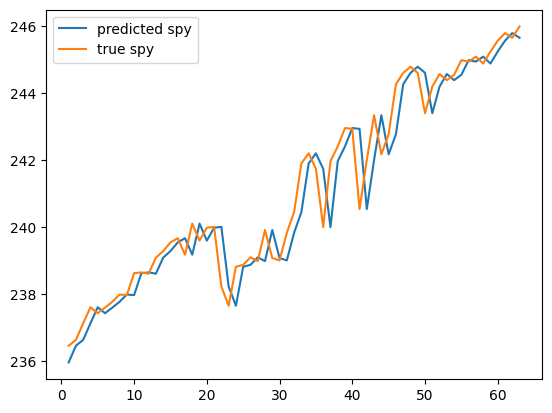

In [ ]:


# def revert_differences(initial_value, differences):
#     # Perform cumulative sum to revert differences
#     prices = differences.cumsum(axis=0) + initial_value
#     return prices

# batch = trainset.__getitem__(5500)
# # get data
# snumin = batch["snumin"].to(device).unsqueeze(0)
# lnumin = batch["lnumin"].to(device).unsqueeze(0)
# numout = batch["numout"].to(device).unsqueeze(0)
# # prepare input to decoder
# decoderin = numout
# # decoderin = torch.zeros(1, output_seq_len, num_numeric_features).to(device)
# decoderin[:,0,:] = numout[:,0,:]
# # get predictions
# total_loss = 0
# for d in range(output_seq_len - 1):
#     preds = model(snumin, lnumin, decoderin)
#     pred = preds[0,d,:] # only take the next days prediction
#     decoderin[:,d+1,:] = pred.detach()

# # today (last day we have access to)
# # print(startday)
# startday = batch["startday"]
# # get scale to inverse transform
# scaler = batch["scale"]
# # initial value to revert the differencing
# initial_value = batch["initial_value"]
# initial_value = initial_value.reshape(1,-1)
# # get original values for prediciton
# preds_unnorm = decoderin[0][:-1,:].detach().cpu().numpy()
# preds_unnorm = revert_differences(initial_value, preds_unnorm)
# preds_unnorm = scaler.inverse_transform(preds_unnorm)
# # make a copy to do percent difference calc
# tensor1 = torch.tensor(preds_unnorm[:,:2])
# preds_unnorm = pd.DataFrame(preds_unnorm, columns=batch["colnames"])

# # get original values for ground truth
# truth = numout[0][1:,:].detach().cpu().numpy()
# truth = revert_differences(initial_value, truth)
# truth = scaler.inverse_transform(truth)
# # make a copy to do percent difference calc
# tensor2 = torch.tensor(truth[:,:2])
# truth = pd.DataFrame(truth, columns=batch["colnames"])

# # plot
# plt.plot(range(1, preds_unnorm.shape[0] + 1), preds_unnorm[["Open_spy"]])
# plt.plot(range(1, truth.shape[0] + 1), truth[["Open_spy"]])
# plt.legend(("predicted spy", "true spy"))
# # plt.ylim(200,500)
# # plt.show()

# # Calculate the absolute difference
# absolute_difference = torch.abs(tensor1 - tensor2)
# # Calculate the average of the two tensors
# avg = (tensor1 + tensor2) / 2
# # Avoid division by zero by adding a small value, epsilon
# epsilon = 1e-8
# avg += epsilon
# # Calculate percent difference
# percent_diff = (absolute_difference / avg) * 100
# print("----% : ", torch.mean(percent_diff).item())
